## Librerias

In [68]:
import pandas as pd
from scipy.stats import shapiro
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest
import datetime  # Usar la biblioteca estándar datetime
plt.rcParams['text.usetex'] = False  # Desactivar el uso de LaTeX
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, close, subplots, title
import requests
import io
from statsmodels.tsa import stattools
from sklearn.metrics import r2_score
import seaborn as sns
# from pmdarima import arima
# from pmdarima import datasets
# from pmdarima import utils
import warnings
import ta
import yfinance as yf
from ta import trend
from statsmodels.tsa import seasonal
import os
import pickle
warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error


## Procesamiento de los datos

In [42]:
# Descargar datos históricos de XRP-USD
data = yf.download('XRP-USD', start='2022-01-01', end='2023-01-01')
data = data.reset_index()
# Mostrar los primeros registros del dataset para revisión
print(data.head())

[*********************100%***********************]  1 of 1 completed

        Date      Open      High       Low     Close  Adj Close      Volume
0 2022-01-01  0.831281  0.853198  0.830741  0.849472   0.849472  1156464024
1 2022-01-02  0.849442  0.863558  0.839157  0.859118   0.859118  1134033205
2 2022-01-03  0.859107  0.859107  0.824052  0.832885   0.832885  1428968710
3 2022-01-04  0.832851  0.844076  0.819615  0.824673   0.824673  1514079366
4 2022-01-05  0.824714  0.835533  0.732704  0.774358   0.774358  2252733064


### Info datos

In [43]:
data.info()# Información relevante de la data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       365 non-null    datetime64[ns]
 1   Open       365 non-null    float64       
 2   High       365 non-null    float64       
 3   Low        365 non-null    float64       
 4   Close      365 non-null    float64       
 5   Adj Close  365 non-null    float64       
 6   Volume     365 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 20.1 KB


Notamos que no hay datos faltantes.

######  ${\huge\bf\mathcal{Análisis\ Exploratorio\ de\ la\ serie\ de\ tiempo\ }}$

In [44]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,3.650000e+02
mean,2022-07-01 23:59:59.999999744,0.514344,0.527474,0.498065,0.513003,0.513003,1.686076e+09
min,2022-01-01 00:00:00,0.308033,0.317014,0.290579,0.308090,0.308090,2.253910e+08
25%,2022-04-02 00:00:00,0.366025,0.376724,0.352447,0.365723,0.365723,1.028960e+09
50%,2022-07-02 00:00:00,0.422457,0.441267,0.405365,0.422337,0.422337,1.456446e+09
75%,2022-10-01 00:00:00,0.712790,0.728245,0.694275,0.707705,0.707705,2.091887e+09
max,2022-12-31 00:00:00,0.877515,0.911137,0.855211,0.878194,0.878194,7.798771e+09
std,NaN,0.181334,0.186086,0.176290,0.180812,0.180812,9.666847e+08


**Gráfico de la serie, autocorrelación y autocorrelación parcial**

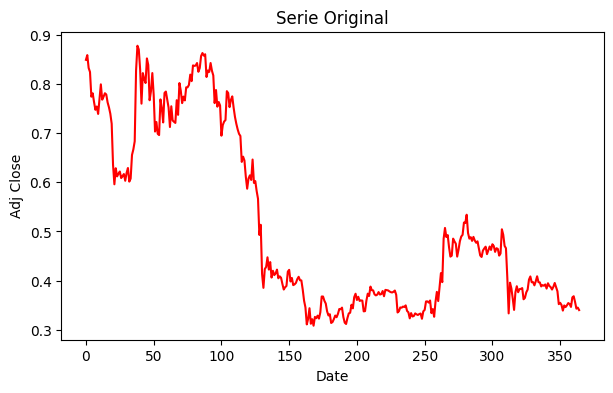

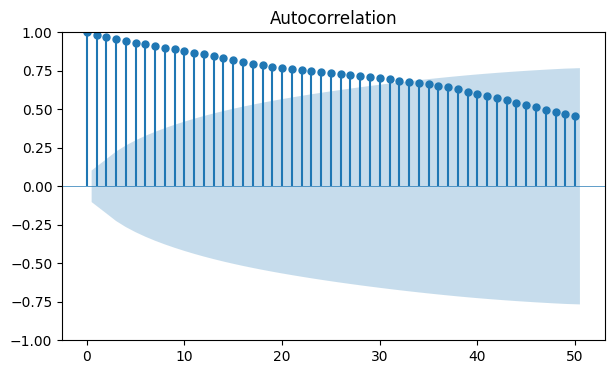

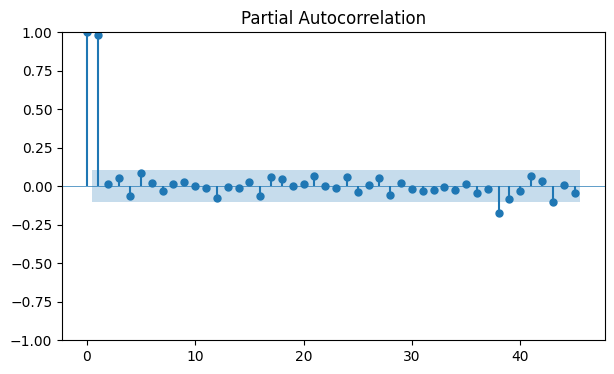

In [45]:
if data['Adj Close'].isnull().sum() > 0:
    data['Adj Close'] = data['Adj Close'].fillna(method='ffill')


plt.rcParams.update({'figure.figsize': (7, 4)})
plt.rcParams['text.usetex'] = False  # Desactivar el uso de LaTeX

nlag = 50

# Serie original
data['Adj Close'].plot(color='r')
plt.title('Serie Original')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

# Autocorrelación y autocorrelación parcial
plot_acf(data['Adj Close'], lags=nlag, linewidth=0.5)  # Autocorrelación
plt.show()

plot_pacf(data['Adj Close'], lags=45, linewidth=0.5)  # Autocorrelación Parcial
plt.show()

1. El patrón observado sugiere una serie con tendencia, ya que los primeros rezagos muestran una autocorrelación fuerte y positiva.
2. Este tipo de patrón es típico de una serie que podría ajustarse bien a un modelo autoregresivo (AR), donde los valores futuros dependen de sus valores pasados.
3. La forma de este PACF, con una fuerte correlación en el lag 1 y ninguna correlación significativa más allá de eso, es típica de una serie temporal que podría ajustarse bien a un modelo AR(1) (Autoregressive Model de orden 1). En este tipo de modelo, el valor actual está determinado principalmente por el valor inmediato anterior.

En presencia de una autocorrelación, es necesario diferenciar la serie del precio de cierre de XRP. por tal motivo las hipótesis a plantear son:

 **H0 : ρ =0** La serie tiene una raíz unitaria y no es estacionaria.

 **H1 : ρ <0** La serie no tiene una raíz unitaria y es estacionaria.

In [46]:
adf_result = adfuller(data["Adj Close"].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -1.705680
p-value: 0.428188


* Idealmente, un valor más negativo del estadístico ADF representará una señal estacionaria, en este caso de **XRP** (-1.131586), podria **NO** ser  **Estacionaria**



* Dado que **𝑝-value**= 0.428188 > 0.05. de Adfuller es mayor que un determinado valor alfa especificado (5%, nivel de significación o intervalo de confianza del 95%), No se rechaza la hipótesis nula (𝐻𝑜) es decir, la serie temporal No es estacionaria.

**Descomposición de la serie**

In [47]:
decompose_model = seasonal.seasonal_decompose(data["Adj Close"].tolist(),
period=20, model='additive')

Text(0.5, 1.0, 'Variaciones irregulares del precio de cierre XRP')

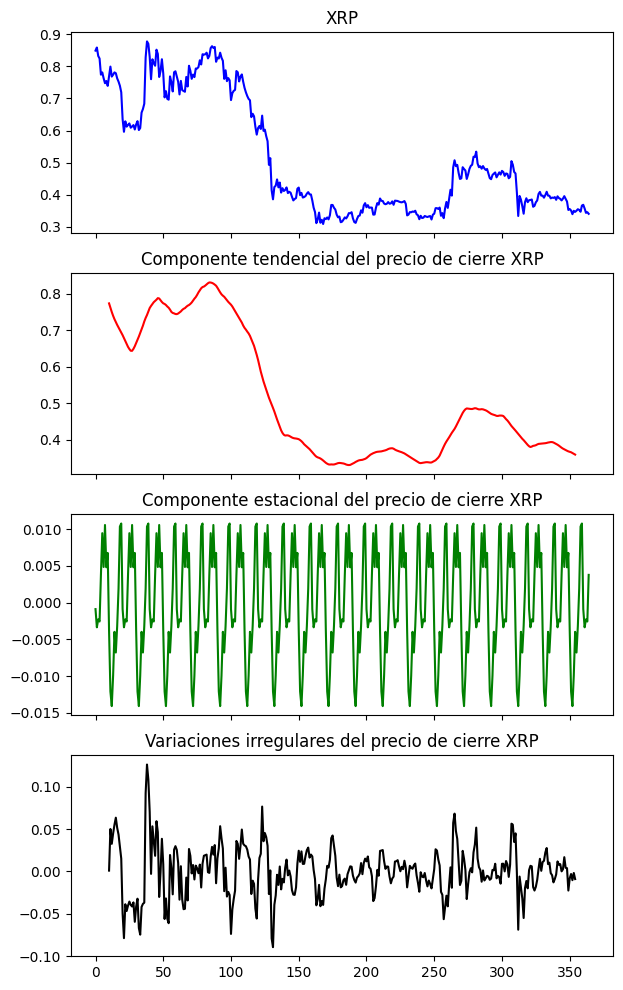

In [48]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(7, 12)

data['Adj Close'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('XRP')

pd.Series(data=decompose_model.trend, index=data.index).plot(color='r',
linestyle='-', ax=axarr[1])
axarr[1].set_title('Componente tendencial del precio de cierre XRP')

pd.Series(data=decompose_model.seasonal, index=data.index).plot(color='g',
linestyle='-', ax=axarr[2])
axarr[2].set_title('Componente estacional del precio de cierre XRP')

pd.Series(data=decompose_model.resid, index=data.index).plot(color='k',
linestyle='-', ax=axarr[3])
axarr[3].set_title('Variaciones irregulares del precio de cierre XRP')

En este caso, parece haber un ciclo estacional periódico muy pronunciado y regular, con subidas y bajadas repetitivas que ocurren en intervalos similares.

Al observar las variaciones irregulares, podemos notar picos significativos a principios de año (por ejemplo, febrero), que podrían deberse a eventos o noticias inesperadas en el mercado. A lo largo del año, la volatilidad parece disminuir, aunque sigue habiendo variaciones más pequeñas y esporádicas.

In [49]:
adf_result = stattools.adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]],autolag='AIC')
print('p-val de la prueba ADF sobre variaciones irregulares en los datos del precio BNB:',
adf_result[1])

p-val de la prueba ADF sobre variaciones irregulares en los datos del precio BNB: 6.891765254891947e-09


la serie ha sido modelada correctamente en términos de sus componentes observables (tendencia y estacionalidad), y que las variaciones no siguen ningún patrón predecible, lo que es esperable en los residuos de un buen modelo.

**Prueba de Normalidad**

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\graphics\gofplots.py:1043: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.



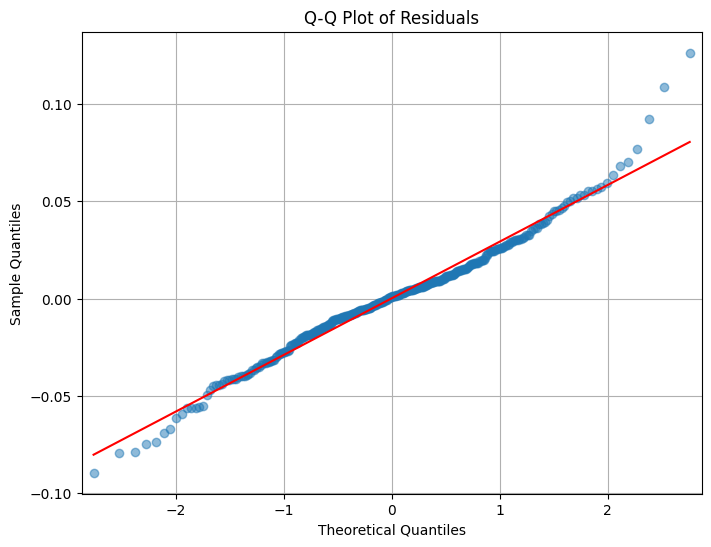

In [50]:
decompose_model = seasonal.seasonal_decompose(data['Adj Close'], period=20, model='additive')

plt.rcParams.update({'figure.figsize': (8, 6)})
fig = sm.qqplot(decompose_model.resid.dropna(), line='s', alpha=0.5, color='b', lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.grid(True)
plt.show()

los residuos siguen una distribución aproximadamente normal, especialmente en la parte central de la distribución. Sin embargo, hay algunas desviaciones en los extremos, lo que indica que hay más valores extremos (outliers) de lo que una distribución normal esperaría. Esto es común en datos financieros y puede deberse a eventos no previstos o anomalías en los precios de XRP.

La normalidad también puede evaluarse mediante la prueba de **Shapiro-Wilk** para la presencia de una normalidad se plantean las siguientes hipótesis

 **H0 :  La muestra parece provenir de una distribución normal**

 **H1 : La muestra no parece provenir de una distribución normal**


In [51]:
resid_clean = decompose_model.resid.replace([np.inf, -np.inf], np.nan).dropna()

# Realizar la prueba de Shapiro-Wilk
stat, p = shapiro(resid_clean)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpretación de los resultados
alpha = 0.05
if p > alpha:
    print('La muestra parece normal (no se rechaza H0)')
else:
    print('La muestra no parece normal (se rechaza H0)')

Statistics=0.980, p=0.000
La muestra no parece normal (se rechaza H0)


In [52]:
print(data.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [53]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data.index,  # Usar el índice de fechas como eje x
                                     open=data['Open'], 
                                     high=data['High'],
                                     low=data['Low'], 
                                     close=data['Close']
                                    )
                     ])
fig.update_layout(
    title="XRP",
    xaxis_title="Date",  # Cambiar el título del eje x para reflejar que es una fecha
    yaxis_title="XRP-USD",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.update_layout(xaxis_rangeslider_visible=False)  # Ocultar el control deslizante de rango
fig.show()  # Mostrar el gráfico


In [56]:
n_AAPL = len(data.Close)  # Cambié 'close' por 'Close' 
n_test = 28  # Esto puede ser cambiado
train_size = n_AAPL - n_test

# Dividiendo los datos en conjunto de entrenamiento y prueba
train = data.Close[:train_size]  # Cambié 'AAPL_df' por 'data' y 'close' por 'Close'
dates_train = data.Date[:train_size]  # Cambié 'AAPL_df' por 'data'
test_4w = data.Close[train_size:train_size + n_test]  # Cambié 'AAPL_df' por 'data' y 'close' por 'Close'
dates_4w = data.Date[train_size:train_size + n_test]  # Cambié 'AAPL_df' por 'data'

# Imprimiendo las dimensiones de los conjuntos de entrenamiento y prueba
print("train:", train.shape)
print("test_4w:", test_4w.shape)

# Creación de los DataFrames de entrenamiento y prueba
train_df = data[["Close"]][:train_size]  # Cambié 'AAPL_df' por 'data' y 'close' por 'Close'
test_data = data[["Close"]][train_size:train_size + n_test]  # Cambié 'AAPL_df' por 'data' y 'close' por 'Close'

# Mostrar los primeros registros del conjunto de prueba
test_data.head()  # Corregí 'test_fata.head()' por 'test_data.head()'


train: (337,)
test_4w: (28,)


,Close
337,0.390735
338,0.389584
339,0.392094
340,0.383721
341,0.394545


In [59]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmo

In [60]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -1533.89413 | order: (2, 1, 2)


In [61]:
model = ARIMA(train, order=best_order)
model_fit = model.fit()

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



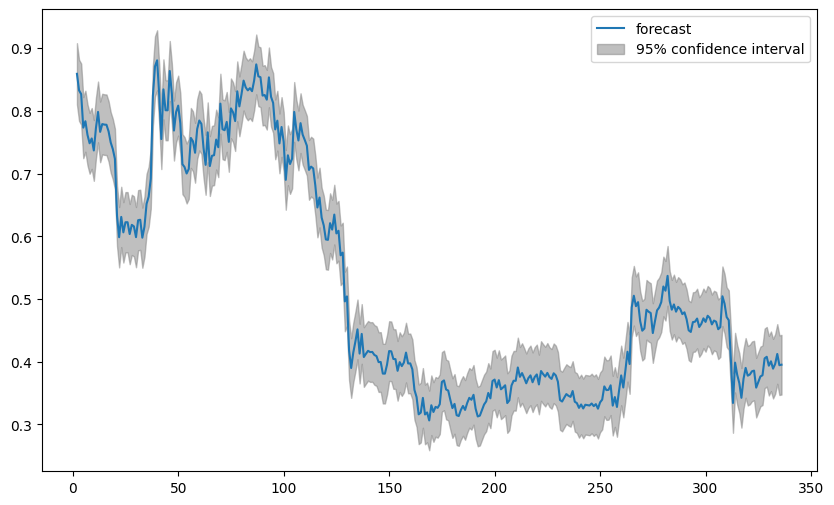

In [63]:
from statsmodels.graphics.tsaplots import plot_predict
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_fit, 2, ax=ax);
plt.show();

In [64]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [58]:
data_AIC = pd.DataFrame(aicVal, columns=['AR(p)', 'd', 'MA(q)', 'AIC'])
data_AIC

,AR(p),d,MA(q),AIC
0,0,1,0,-1680.864688
1,0,1,1,-1679.729393
2,0,1,2,-1678.619647
3,1,1,0,-1679.641010
4,1,1,1,-1678.857112
5,1,1,2,-1681.349601
6,2,1,0,-1678.887835
7,2,1,1,-1676.778819
8,2,1,2,-1687.046037
9,0,2,0,-1407.331451


In [65]:
def arima_rolling(history, test):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [66]:
test_4wl = test_4w.tolist()
yhat_4w  = arima_rolling(train.tolist(), test_4wl)

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.391313, expected=0.390735


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.388505, expected=0.389584


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.389335, expected=0.392094


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.395088, expected=0.383721


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.380993, expected=0.394545


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.395319, expected=0.389153
predicted=0.391426, expected=0.386698
predicted=0.384881, expected=0.381749


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.383103, expected=0.387394
predicted=0.388925, expected=0.395102


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.392876, expected=0.386414


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.387078, expected=0.378237


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.379990, expected=0.351988


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.348756, expected=0.354810


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.356527, expected=0.350270


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.350062, expected=0.338870


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.336134, expected=0.349373


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.351395, expected=0.346020


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.345519, expected=0.349600


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.346824, expected=0.354273


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.355849, expected=0.352179


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.350825, expected=0.346392


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.345675, expected=0.365723


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.367463, expected=0.368126


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.365962, expected=0.356531


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.357174, expected=0.342846


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.346095, expected=0.345017
predicted=0.342714, expected=0.339929


c:\Users\EMANUEL\miniconda3\envs\Eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [69]:
forecast_accuracy(np.array(test_4wl), np.array(yhat_4w), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,0.007401,0.000092,0.020225,0.009578,0.761286


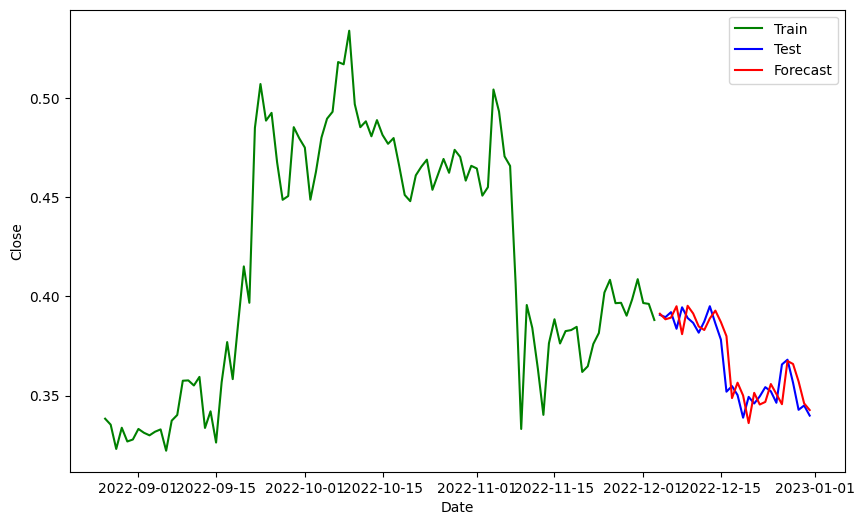

In [70]:
ax = sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=dates_4w, y=test_4wl, label="Test", color='b')
sns.lineplot(x=dates_4w, y=yhat_4w, label="Forecast", color='r')
plt.show()

### 21 dias

***Criterios AIC, BIC, HQIC***